In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

In [2]:
df = pd.read_csv('final_preprocessed_training_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   fips_code                             1000 non-null   int64  
 1   incident_start_date                   1000 non-null   object 
 2   is_major_disaster                     1000 non-null   int64  
 3   state                                 1000 non-null   object 
 4   incident_year                         1000 non-null   int64  
 5   area_name                             974 non-null    object 
 6   data_year                             974 non-null    float64
 7   medhhinc                              1000 non-null   float64
 8   povall                                1000 non-null   float64
 9   civilian_labor_force                  1000 non-null   float64
 10  employed                              1000 non-null   float64
 11  unemployed        

In [4]:
#seperating features from target , and dropping non numeric identifiers since it would cause leakage
features_to_exclude = [
    'fips_code', 'incident_start_date', 'state', 'area_name',
    'data_year', 'vulnerability_ratio', 'is_major_disaster'
]

In [5]:
X = df.drop(columns=[c for c in features_to_exclude if c in df.columns])
y = df['is_major_disaster']

In [6]:
X

,incident_year,medhhinc,povall,civilian_labor_force,employed,unemployed,unemployment_rate,med_hh_income_percent_of_state_total,total_population,total_population_norm,priority_index,type_Biological,type_Fire,type_Flood,type_Hurricane,type_Severe Storm,type_Straight-Line Winds,type_Tornado,type_Winter Storm
0,2024,103486.0,48317.0,332643.0,321932.0,10711.0,3.2,130.5,598865.0,0.061969,0.031004,False,True,False,False,False,False,False,False
1,2024,68419.0,3390.0,10286.0,9814.0,472.0,4.6,86.7,25454.0,0.002630,0.003232,False,True,False,False,False,False,False,False
2,2024,95414.0,17944.0,104662.0,100812.0,3850.0,3.7,111.4,208513.0,0.021573,0.012449,False,True,False,False,False,False,False,False
3,2017,65813.0,5775.5,19564.0,18492.0,747.0,3.9,NaN,43712.0,0.004519,0.005775,False,False,False,False,True,False,False,False
4,2015,68857.0,7004.0,27000.0,26409.0,591.0,2.2,117.5,60342.0,0.006240,0.006704,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2025,58639.0,600.0,2191.0,2105.0,86.0,3.9,92.0,4704.0,0.000482,0.000616,False,False,False,False,True,False,False,False
996,2025,53894.0,1560.0,3720.0,3568.0,152.0,4.1,85.2,8974.0,0.000924,0.001861,False,False,False,False,True,False,False,False
997,2025,43127.0,1364.0,3456.0,3339.0,117.0,3.4,82.5,6000.0,0.000616,0.002040,False,False,False,False,True,False,False,False
998,2025,56545.0,1968.0,4769.0,4527.0,242.0,5.1,86.8,12448.0,0.001284,0.002251,False,False,False,False,True,False,False,False


In [7]:
y

,is_major_disaster
0,0
1,0
2,0
3,1
4,1
...,...
995,1
996,1
997,1
998,1


In [8]:
#train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [9]:
print(f"Data Loaded: {X_train.shape[0]} training samples and {X_test.shape[0]} test samples.")
print(f"Features utilized: {X.columns.tolist()}")

Data Loaded: 800 training samples and 200 test samples.
Features utilized: ['incident_year', 'medhhinc', 'povall', 'civilian_labor_force', 'employed', 'unemployed', 'unemployment_rate', 'med_hh_income_percent_of_state_total', 'total_population', 'total_population_norm', 'priority_index', 'type_Biological', 'type_Fire', 'type_Flood', 'type_Hurricane', 'type_Severe Storm', 'type_Straight-Line Winds', 'type_Tornado', 'type_Winter Storm']


In [10]:
#loading the XGBoost classifier model
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

In [11]:
model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [19:29:21] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [12]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [15]:
print("Baseline Model Performance")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Baseline Model Performance
Accuracy: 0.9750
ROC-AUC Score: 0.9968

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       114
           1       0.99      0.95      0.97        86

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200



<Figure size 1000x800 with 0 Axes>

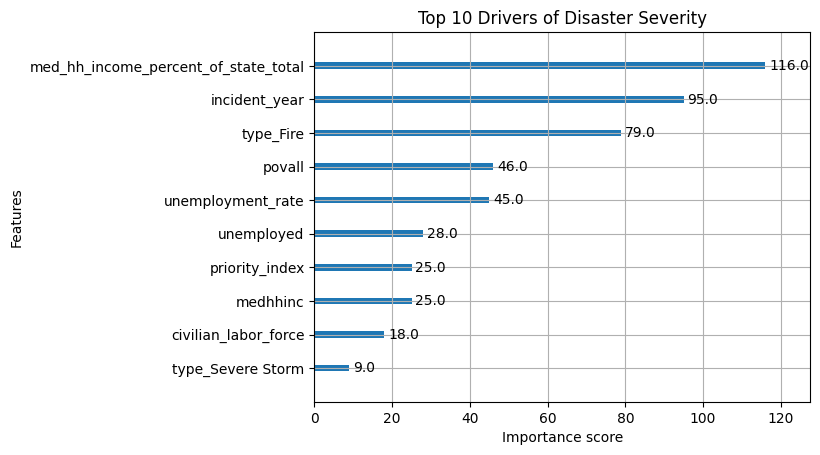

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
xgb.plot_importance(model, max_num_features=10, importance_type='weight')
plt.title("Top 10 Drivers of Disaster Severity")
plt.show()

So as expected , there is temporal leakage problem since it learnt from historical data than recent incidents